# Exploratory Data Analysis |  Modeling Spotify track popularity
## Leo Evancie, Springboard Data Science Career Track

This is the second step in a capstone project to model music popularity on Spotify, a popular streaming service. Further project details and rationale can be found in the document 'Proposal.pdf'.

In this notebook, I will take a deeper dive into my cleaned dataset of nearly 10,000 tracks pulled from Spotify's API. I will visualize key relationships and look for clues to help guide the later development of my model.

First, I'll load packages and read my cleaned data into a DataFrame:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/cleaned.csv', index_col=0)

I looked at the `popularity` column while data wrangling. Here, again, is its distribution:

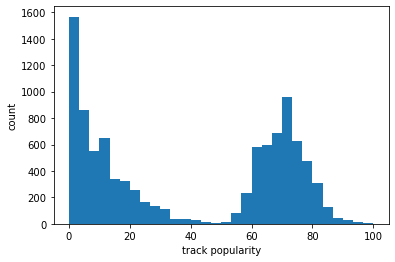

In [3]:
plt.hist('popularity', data=df, bins=30)
plt.xlabel('track popularity')
plt.ylabel('count')
plt.show()

As mentioned in the previous notebook, the large number of tracks with a `popularity` of zero means that a classification model may be more appropriate, rather than trying to model the specific value from 0 to 100. Looking at the above distribution, a score of 50 or higher seems like a good cutoff. I can use that to create a Boolean column to represent the binary state of popular / not popular.

In [4]:
df['popularity_bool'] = df['popularity'] >= 50
df.rename(columns={'popularity':'popularity_int'}, inplace=True)
df[['popularity_int', 'popularity_bool']].head(10)

,popularity_int,popularity_bool
0,82,True
1,58,True
2,60,True
3,33,False
4,76,True
5,56,True
6,78,True
7,25,False
8,81,True
9,51,True


That seems to have worked. How many popular tracks do I have here?

In [5]:
np.sum(df.popularity_bool) / len(df)

0.48568818514007306

It's an even split. This is good. If popular tracks were the vast minority or majority, a classification model would not be as interesting. Still, I will keep `popularity_int` in my dataset, both for its valuable precision and so that I may still attempt a regression model for comparison's sake.

Now, let's get an overview of the correlations between my quantitative variables.

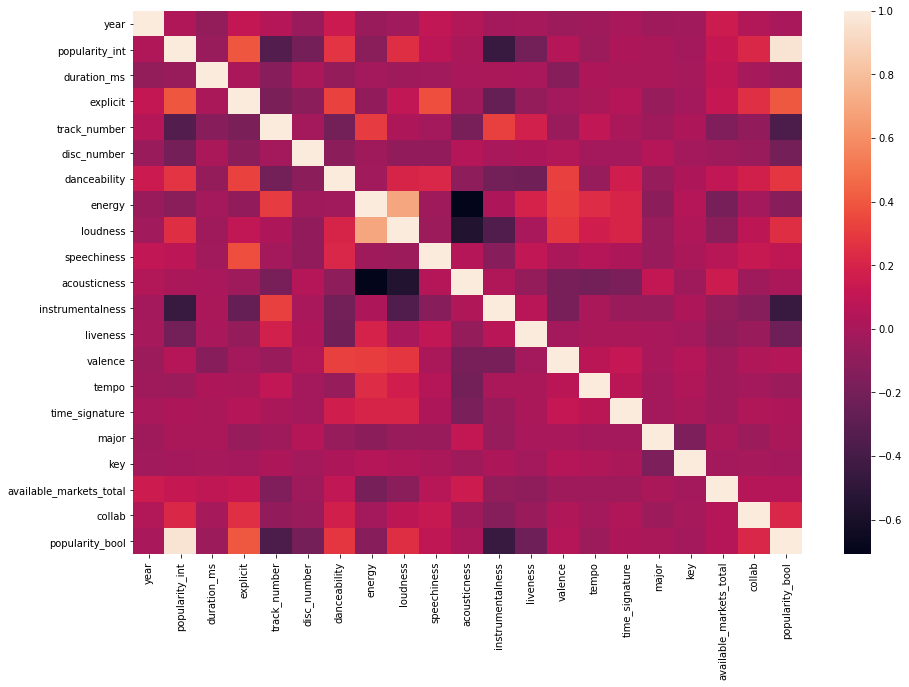

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr())
plt.show()

Obviously, my two popularity columns are near-perfectly correlated. (That's a good reminder to exclude one when trying to model the other.) I notice only a few other positive correlations: `explicit`, `danceability`, `loudness`, and `collab`. None of those are as strong as the negative correlation with `track_number` and `instrumentalness`. Looks like instrumental music fares much worse on Spotify, popularity-wise. But what should we make of `track_number`?

In [7]:
df.track_number.value_counts()

1      1870
2       874
3       819
4       666
5       594
       ... 
105       5
106       2
122       1
107       1
111       1
Name: track_number, Length: 109, dtype: int64

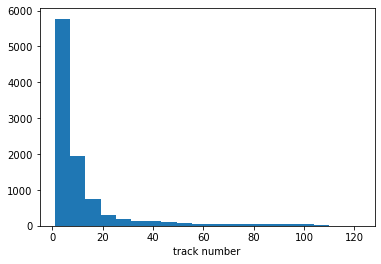

In [8]:
plt.hist('track_number', data=df, bins=20)
plt.xlabel('track number')
plt.show()

Track number appears to be exponentially distributed. This makes intuitive sense. Typically, an album has somewhere around 12 tracks, while anthologies and compliations have more, with successively higher track numbers being decreasingly common. As such, I'm surprised by the much higher track numbers. What kinds of collections have track numbers in the 50s, 60s, even over 100? I can't remember ever encountering such an album.

I will isolate the tracks with notably high track numbers and inspect.

In [9]:
high_tracks = df[df['track_number'] > 40][['name','artist','popularity_bool','track_number']]\
    .sort_values('track_number', ascending=False)
high_tracks.head(10)

,name,artist,popularity_bool,track_number
8597,Stay Loud - Official Decibel outdoor 2020 Tribute,Frequencerz,False,122
7485,Wish Outdoor 2019 Worldwide Anthem,Frequencerz,False,111
5659,A State Of Trance Year Mix 2017 - A Magical Pa...,Armin van Buuren,False,107
7449,A State Of Trance Year Mix 2019 (Mixed) - Outr...,Armin van Buuren,False,106
5623,Leave A Message (Mix Cut),Will Atkinson,False,106
8379,A State Of Trance Year Mix 2020 (Mixed) - Road...,Armin van Buuren,False,105
7317,Stickup (Mixed) - Maarten de Jong Remix,Armin van Buuren,False,105
5743,Wraith (Mix Cut),DRYM,False,105
6443,A State Of Trance Year Mix 2018 (Mixed) - Outr...,Armin van Buuren,False,105
5927,Wraith,DRYM,False,105


As expected, there are just a few artists accounting for the bulk of the high track numbers. Just how many?

In [10]:
high_track_artists = high_tracks.artist.unique()
len(high_track_artists)

237

How does that compare to the total artists?

In [11]:
len(high_track_artists) / len(df.artist.unique())

0.07655038759689922

Just 0.08% of artists in the sample have any tracks with a higher track number than 40. What about the numbers of tracks?

In [12]:
len(high_tracks) / len(df)

0.06699147381242387

So, a similar proportion of tracks in the sample -- about 0.07% -- have a `track-number` higher than 40. This is such a small slice that it's tempting to remove it from the sample entirely. However, it is arguably a valid insight that tracks appearing in the latter portion of super-long albums and collections tend to have lower popularity, even if relatively few such collections exist. Indeed, this analysis could support the idea that artists hoping to optimize for popularity should stick to the conventional album length.

But to fully understand the relationship, we must explore the notion of a "single." Artists often do not release entire albums, but single standalone tracks. In such cases, the `track_number` value would presumably be 1. This could potentially cause misinterpretation of the simple relationship between track number and popularity. For example, if

* singles have `track_number` 1 in the dataset, and
* singles tend to be more popular than tracks from albums, (which seems likely, due to the prevalence of singles in pop music),

then we would see an artificially inflated importance of early track numbers (particularly track number 1) in predicting popularity.

I will split the data into singles and albums to reassess the popularity distributions and associations.

In [13]:
singles = df[df.album_type == 'single']
albums = df[df.album_type != 'single']

In [14]:
len(singles) / len(df)

0.14514819326025172

Singles make up 14.5% of the sample. Let's test the first assumption from above: Singles in the dataset have `track_number` = 1.

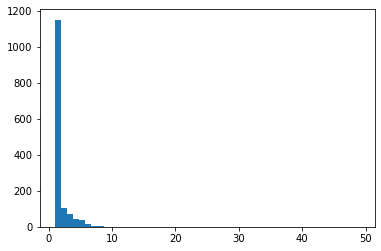

In [15]:
plt.hist(singles.track_number, bins=50)
plt.show()

I see that this assumption was not entirely correct. While the vast majority of singles have `track_number` = 1, there are a few with higher track numbers. This is close enough, though, to still cause a potential issue with interpretation.

Now let's check assumption two: Singles are more popular.

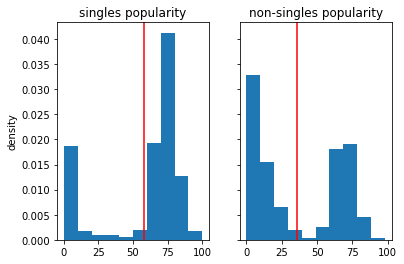

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist('popularity_int', data=singles, density=True, bins=10)
axs[0].axvline(singles.popularity_int.mean(), color='r')
axs[0].set_title('singles popularity')
axs[0].set_ylabel('density')
axs[1].hist('popularity_int', data=albums, density=True, bins=10)
axs[1].axvline(albums.popularity_int.mean(), color='r')
axs[1].set_title('non-singles popularity')

plt.show()

For singles, popularity is distributed unimodally, with the addition of a cluster of zeroes. Even with said cluster, the mean is much higher than the popularity of non-single tracks, which has a bimodal distribution, with a greater density of tracks in the low range.

Therefore, I need to be mindful when ascribing importance of `track_number` to popularity. Part of the covariance between these two variables can be explained by whether or not the track is a single.

And so, as I did with popularity, I will create a new Boolean column to indicate whether a track is a single.

In [17]:
df['single'] = df['album_type'] == 'single'
df[['album_type', 'single']].head(10)

,album_type,single
0,album,False
1,album,False
2,album,False
3,single,True
4,album,False
5,single,True
6,single,True
7,single,True
8,album,False
9,single,True


With this new feature available, I'll check the correlation heatmap again.

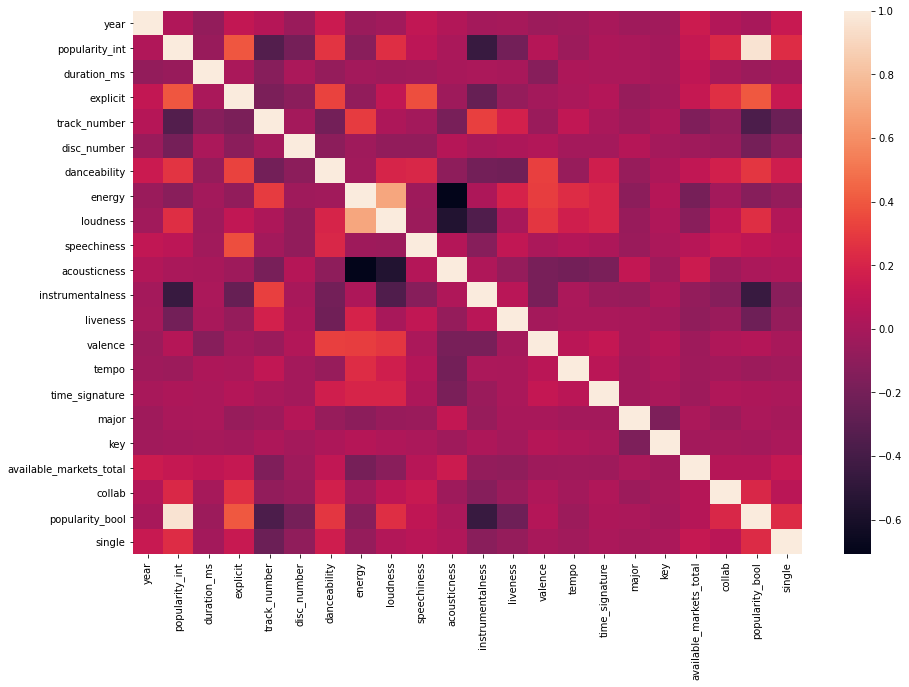

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr())
plt.show()

Looks like there's a modest correlation between popularity and singles. Let's isolate what appear to be some of the most noteworthy associations and look at the values. I will include both popularity columns out of curiosity for how their respective correlations will differ.

In [19]:
df[['popularity_int', 'popularity_bool', 'explicit', 'track_number', 'danceability', 'speechiness',\
    'available_markets_total', 'single']].corr()

,popularity_int,popularity_bool,explicit,track_number,danceability,speechiness,available_markets_total,single
popularity_int,1.000000,0.962547,0.395777,-0.337423,0.277747,0.081185,0.119345,0.244289
popularity_bool,0.962547,1.000000,0.400368,-0.362931,0.285391,0.096418,0.053120,0.233769
explicit,0.395777,0.400368,1.000000,-0.168758,0.330124,0.369945,0.122941,0.129150
track_number,-0.337423,-0.362931,-0.168758,1.000000,-0.204532,-0.018794,-0.155112,-0.237193
danceability,0.277747,0.285391,0.330124,-0.204532,1.000000,0.213082,0.103247,0.163039
speechiness,0.081185,0.096418,0.369945,-0.018794,0.213082,1.000000,0.060176,0.070629
available_markets_total,0.119345,0.053120,0.122941,-0.155112,0.103247,0.060176,1.000000,0.124748
single,0.244289,0.233769,0.129150,-0.237193,0.163039,0.070629,0.124748,1.000000


These are early candidates for features to include in my model, but I'll select features more thoroughly in the next notebook.